## Function counting learning curve

### Issues
- jak ustawiać random_state ?
- funkcja do rysowania wykresów na razie jedynie poglądowa
- 'Data is removed piece by piece from the trainset to obtain smaller trainsets and thus to obtain a learning curve' - narazie zastosowano podejście polegające na losowaniu próbek dla każdego anchor

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Funkcje 

In [113]:
def outer_splits(X, y):
    """
    Dokonuje stratyfikowanych podziałów danych D na zbiory D_learn i D_test w proporcjach 90%, 10%
    Przez dane D rozumiemy D = (X, y), gdzie X i y są podawane osobno jako argumenty

    Parametry:
    - X
    - y

    Zwraca:
    - D_learn: lista, gdzie D_learn[i] zawiera tuple D_learn = (X_train, y_train) od i = 1 do m
    - D_test: lista, gdzie D_test[i] zawiera tuple D_test = (X_test, y_test) od i = 1 do m
    """

    # m: int, liczba podziałów (domyślnie 5)
    # test_size: proporcja zbioru testowego (domyślnie 0.1)
    m = 5
    test_size = 0.1
    random_state = 42

    D_learn = []
    D_test = []
    
    for i in range(m):
        X_learn, X_test, y_learn, y_test = train_test_split(
            X, y, test_size = test_size, stratify = y, random_state=(random_state + 100*i)
        )
        D_learn.append((X_learn, y_learn))
        D_test.append((X_test, y_test))
    
    return D_learn, D_test

In [114]:
def inner_splits(X_learn, y_learn):
    """
    Dokonuje wewnętrznego podziału zbioru D_learn = (X_learn, y_train) na D_train = (X_train, y_train) i D_val = (X_val, y_val)
    
    Parametry:
    - X_learn
    - y_learn

    Zwraca:
    - D_train: lista, gdzie D_train[j] zawiera tuple D_train = (X_train, y_train) dla j = 1 do n
    - D_val: lista, gdzie D_val[j] zawiera tuple D_val = (X_val, y_val) dla j = 1 do n
    """
    # n: int, liczba podziałów (domyślnie 5)
    # val_size: float, proporcja zbioru walidacyjnego względem D_learn (domyślnie 0.1)
    n = 5
    val_size = 0.1
    random_state = 42

    D_train = []
    D_val = []

    for j in range(n):
        X_train, X_val, y_train, y_val = train_test_split(
            X_learn, y_learn, test_size = val_size, stratify = y_learn, random_state=(random_state + 100*j)
        )
        D_train.append((X_train, y_train))
        D_val.append((X_val, y_val))
    
    return D_train, D_val

In [115]:
def anchors_split(X_train, y_train):
    """
    Tworzy D_train_anchors, gdzie każdy zbiór D_train_anchors[k] zawiera losowe próbki 
    z D_train o rozmiarze ceil(2^((7 + k) / 2)).
    
    Parametry:
    - X_train
    - y_train
    -- k_max: int, maksymalny indeks k (rozmiar D_train_anchors będzie wynosił k_max)
    
    Zwraca:
    - D_train_anchors: lista rozmiaru k_max, gdzie D_train_anchors[k] = (X_anchor, y_anchor); X_train i y_anchor są rozmiaru k-tego anchor 
    """
    random_state = 42
    np.random.seed(random_state)
    total_samples = len(X_train)
    D_train_anchors = []

    # Wyznaczenie maksymalnej liczby anchorów dla danego X_train
    # k_max to maksymalny anchor
    k_max = 0
    while True:
        anchor_size = ceil(2 ** ((7 + k_max + 1) / 2))
        if anchor_size > total_samples:
            break
        k_max += 1


    for k in range(1, k_max + 1):
        anchor_size = ceil(2 ** ((7 + k) / 2))
        #anchor_size = min(anchor_size, total_samples)

        # Losowy wybór indeksów próbek
        indices = np.random.choice(total_samples, size=anchor_size, replace=False)
        X_anchor = X_train.iloc[indices] if isinstance(X_train, pd.DataFrame) else X_train[indices]
        y_anchor = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]
        
        D_train_anchors.append((X_anchor, y_anchor))

    return D_train_anchors

In [126]:
def learning_curve(X, y, model_type = "decision_tree"):
    """
    Funkcja generująca dane do utworzenia learning curve - anchor_sizes, scores_train, scores_valid, scores_test 

    Parametry:
    - X
    - y
    - model_type: str, "decision_tree" lub "random_forest"

    Zwraca:
    - anchor_sizes: list, lista zawierająca anchors o rozmiarze mniejszym niż zbiór X
    - scores_train: list of lists, accuracy dla każdego anchoru na zbiorze treningowym.
    - scores_valid: list of lists, accuracy dla każdego anchoru na zbiorze walidacyjnym.
    - scores_test: list of lists, accuracy dla każdego anchoru na zbiorze testowym.
    """
    random_state = 42
    k_max = 24  
    # k_max  - sztuczne ograniczenie na maksymalną liczbę anchorów; dla k_max = 24 odpowiadający anchor to 65536

    scores_train = [[] for _ in range(k_max)]
    scores_valid = [[] for _ in range(k_max)]
    scores_test = [[] for _ in range(k_max)]


    ### PIPELINE

    if   model_type == "decision_tree":
            model_class = DecisionTreeClassifier
    elif model_type == "random_forest":
            model_class = RandomForestClassifier
    else:
         raise ValueError("Użyj 'decision_tree' lub 'random_forest'.")

    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns

    numeric_transformer = SimpleImputer(strategy="median")
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model_class(random_state=random_state))
    ])


    ## OUTER SPLIT
    D_learn, D_test = outer_splits(X, y)

    
    # Iteracja po zewnętrznych splitach D_learn 
    for i in range(len(D_learn)):
        X_learn, y_learn = D_learn[i][0], D_learn[i][1]
        X_test, y_test = D_test[i][0], D_test[i][1]

        # INNER SPLIT dla każdego D_learn = (X_learn, y_learn)
        D_train, D_val = inner_splits(X_learn, y_learn)

        # Iteracja po wewnętrznych splitach D_train = (X_train, y_train)
        for j in range(len(D_train)):
            X_train, y_train = D_train[j][0], D_train[j][1]
            X_val, y_val = D_val[j][0], D_val[j][1]

            # Generowanie anchorów dla każdego D_train = (X_train, y_train)
            D_train_anchors = anchors_split(X_train, y_train)

            # Iteracja po anchorach 
            for k in range(len(D_train_anchors)):
                X_train_anchor, y_train_anchor = D_train_anchors[k][0], D_train_anchors[k][1]

                # Trenowanie modelu na danym podzbiorze danych
                pipeline.fit(X_train_anchor, y_train_anchor)

                y_train_pred = pipeline.predict(X_train_anchor)
                y_val_pred = pipeline.predict(X_val)
                y_test_pred = pipeline.predict(X_test)

                # Zapisywanie dokładności do odpowiednich struktur wyników.
                scores_train[k].append(accuracy_score(y_train_anchor, y_train_pred))
                scores_valid[k].append(accuracy_score(y_val, y_val_pred))
                scores_test[k].append(accuracy_score(y_test, y_test_pred))

    # Obliczanie rozmiarów anchorów 
    anchor_sizes = []
    for k in range(1, len(D_train_anchors) + 1):  # k iteruje od 1 do maksymalnej liczby anchorów.
        anchor_size = ceil(2 ** ((7 + k) / 2))  
        anchor_sizes.append(anchor_size)

    # Dopasowanie wyników do liczby anchorów -> żeby nie zwracało pustych list
    kmax = len(anchor_sizes)
    return anchor_sizes, [sublist[:kmax] for sublist in scores_train[:kmax]], \
           [sublist[:kmax] for sublist in scores_valid[:kmax]], \
           [sublist[:kmax] for sublist in scores_test[:kmax]]

    # Opcjonalnie zamiast wszystkich wyników zwracanie tylko średnich
    #mean_scores_train = [sum(sublist) / len(sublist) if sublist else 0 for sublist in scores_train]
    #mean_scores_valid = [sum(sublist) / len(sublist) if sublist else 0 for sublist in scores_valid]
    #mean_scores_test = [sum(sublist) / len(sublist) if sublist else 0 for sublist in scores_test]

    #return anchor_sizes, mean_scores_train[:len(anchor_sizes)], mean_scores_valid[:len(anchor_sizes)], mean_scores_test[:len(anchor_sizes)]

In [148]:
### Narazie tylko w celach poglądowych
def plot_learning_curve(anchor_sizes, scores_train, scores_valid, scores_test):
    """
    Rysuje krzywe uczenia na podstawie podanych wyników.

    Parametry:
    - anchor_sizes: list, rozmiary anchorów
    - scores_train: list of lists, wyniki na zbiorze treningowym dla każdego rozmiaru anchorów
    - scores_valid: list of lists, wyniki na zbiorze walidacyjnym dla każdego rozmiaru anchorów
    - scores_test: list of lists, wyniki na zbiorze testowym dla każdego rozmiaru anchorów
    """
    mean_train = [np.mean(scores) for scores in scores_train]
    std_train = [np.std(scores) for scores in scores_train]

    mean_valid = [np.mean(scores) for scores in scores_valid]
    std_valid = [np.std(scores) for scores in scores_valid]

    mean_test = [np.mean(scores) for scores in scores_test]
    std_test = [np.std(scores) for scores in scores_test]

    # Tworzenie wykresu
    plt.figure(figsize=(8, 6))
    
    # Wykres dla wyników treningowych
    plt.plot(anchor_sizes, mean_train, label="Performance on Training Data", color="blue")
    plt.fill_between(anchor_sizes, 
                     np.array(mean_train) - np.array(std_train), 
                     np.array(mean_train) + np.array(std_train), 
                     color="blue", alpha=0.2)
    
    # Wykres dla wyników walidacyjnych
    plt.plot(anchor_sizes, mean_valid, label="Performance on Validation Data", color="orange")
    plt.fill_between(anchor_sizes, 
                     np.array(mean_valid) - np.array(std_valid), 
                     np.array(mean_valid) + np.array(std_valid), 
                     color="orange", alpha=0.2)
    
    # Wykres dla wyników testowych
    plt.plot(anchor_sizes, mean_test, label="Performance on Test Data", color="green")
    plt.fill_between(anchor_sizes, 
                     np.array(mean_test) - np.array(std_test), 
                     np.array(mean_test) + np.array(std_test), 
                     color="green", alpha=0.2)

    # Dostosowanie wykresu
    plt.xlabel("Number of training instances")
    plt.ylabel("Prediction Performance")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

## Przykłady działania

#### banknote - authentication

In [121]:
df1 = pd.read_csv("banknote-authentication-unprocessed.csv")
df1.head()

,V1,V2,V3,V4,Class
0,3.62160,8.6661,-2.8073,-0.44699,1
1,4.54590,8.1674,-2.4586,-1.46210,1
2,3.86600,-2.6383,1.9242,0.10645,1
3,3.45660,9.5228,-4.0112,-3.59440,1
4,0.32924,-4.4552,4.5718,-0.98880,1


In [122]:
y = df1.Class.map({2: 1, 1: 0})

In [123]:
X = df1.drop(["Class"], axis = 1)

In [100]:
# Outer splits
D_learn, D_test = outer_splits(X, y)

In [101]:
D_learn[0]


(           V1        V2        V3       V4
 297   1.27060   8.03500  -0.19651 -2.18880
 765  -3.84830 -12.80470  15.68240 -1.28100
 575   2.61040   8.00810  -0.23592 -1.76080
 636   2.15260  -6.16650   8.08310 -0.34355
 770   0.34340   0.12415  -0.28733  0.14654
 ...       ...       ...       ...      ...
 1331  0.22432  -0.52147  -0.40386  1.20170
 961  -1.18590  -1.25190   2.26350  0.77239
 615  -0.20620   9.22070  -3.70440 -6.81030
 1143 -2.46210   2.76450  -0.62578 -2.85730
 592   0.95626   2.47280   4.45780  0.21636
 
 [1234 rows x 4 columns],
 297     0
 765     1
 575     0
 636     0
 770     1
        ..
 1331    1
 961     1
 615     0
 1143    1
 592     0
 Name: Class, Length: 1234, dtype: int64)

In [102]:
D_learn[0][0]

,V1,V2,V3,V4
297,1.27060,8.03500,-0.19651,-2.18880
765,-3.84830,-12.80470,15.68240,-1.28100
575,2.61040,8.00810,-0.23592,-1.76080
636,2.15260,-6.16650,8.08310,-0.34355
770,0.34340,0.12415,-0.28733,0.14654
...,...,...,...,...
1331,0.22432,-0.52147,-0.40386,1.20170
961,-1.18590,-1.25190,2.26350,0.77239
615,-0.20620,9.22070,-3.70440,-6.81030
1143,-2.46210,2.76450,-0.62578,-2.85730


In [103]:
D_learn[0][1]

297     0
765     1
575     0
636     0
770     1
       ..
1331    1
961     1
615     0
1143    1
592     0
Name: Class, Length: 1234, dtype: int64

In [104]:
# Inner splits
D_train, D_val = inner_splits(D_learn[0][0], D_learn[0][1])

In [105]:
D_train[0][0]

,V1,V2,V3,V4
618,1.859200,3.20740,-0.15966,-0.26208
1219,-3.579800,0.45937,2.34570,-0.45734
1030,-1.843900,-8.64750,7.67960,-0.66682
652,4.643900,-3.37290,2.59760,0.55257
782,-0.348100,-0.38696,-0.47841,0.62627
...,...,...,...,...
654,3.512700,2.90730,1.05790,0.40774
844,0.009661,3.56120,-4.40700,-4.41030
933,-0.102340,1.81890,-2.21690,-0.56725
398,4.393700,0.35798,2.04160,1.20040


In [106]:
D_train[0][1]

618     0
1219    1
1030    1
652     0
782     1
       ..
654     0
844     1
933     1
398     0
312     0
Name: Class, Length: 1110, dtype: int64

In [107]:
D_test[0][0]

,V1,V2,V3,V4
387,4.63610,-2.66110,2.835800,1.19910
466,1.14720,3.59850,1.938700,-0.43406
214,4.19620,0.74493,0.832560,0.75300
1303,-3.92970,-6.08160,10.095800,-1.01470
787,-2.66850,-10.45190,9.113900,-1.73230
...,...,...,...,...
401,2.21230,-5.83950,7.768700,-0.85302
686,0.76163,5.82090,1.195900,-0.64613
822,-3.07310,-0.53181,2.387700,0.77627
385,2.37180,7.49080,0.015989,-1.74140


In [108]:
# Anchors
D_train_anchors = anchors_split(D_train[0][0], D_train[0][1])

In [109]:
i = 0
while i < len(D_train_anchors):
    print(D_train_anchors[i][0].shape)
    i += 1
# Rozmiar X_train to 1110, czyli największy anchor to 1024

(16, 4)
(23, 4)
(32, 4)
(46, 4)
(64, 4)
(91, 4)
(128, 4)
(182, 4)
(256, 4)
(363, 4)
(512, 4)
(725, 4)
(1024, 4)


In [110]:
D_train_anchors[12][0].shape

(1024, 4)

In [111]:
D_train_anchors[13][0].shape

IndexError: list index out of range

In [127]:
anchor_sizes, scores_train, scores_valid, scores_test = learning_curve(X, y, model_type= 'decision_tree')

In [129]:
anchor_sizes

[16, 23, 32, 46, 64, 91, 128, 182, 256, 363, 512, 725, 1024]

In [131]:
scores_train

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [133]:
scores_test

[[0.8840579710144928,
  0.8768115942028986,
  0.7608695652173914,
  0.7971014492753623,
  0.8333333333333334,
  0.8913043478260869,
  0.8478260869565217,
  0.7391304347826086,
  0.8188405797101449,
  0.8405797101449275,
  0.8188405797101449,
  0.8043478260869565,
  0.6811594202898551],
 [0.8043478260869565,
  0.8913043478260869,
  0.8695652173913043,
  0.8840579710144928,
  0.8405797101449275,
  0.8333333333333334,
  0.7246376811594203,
  0.8623188405797102,
  0.9130434782608695,
  0.8478260869565217,
  0.7318840579710145,
  0.782608695652174,
  0.8623188405797102],
 [0.782608695652174,
  0.8695652173913043,
  0.8478260869565217,
  0.9057971014492754,
  0.9130434782608695,
  0.8840579710144928,
  0.8985507246376812,
  0.855072463768116,
  0.9130434782608695,
  0.8188405797101449,
  0.7971014492753623,
  0.6884057971014492,
  0.8260869565217391],
 [0.8623188405797102,
  0.8478260869565217,
  0.7536231884057971,
  0.8768115942028986,
  0.8913043478260869,
  0.8768115942028986,
  0.891304

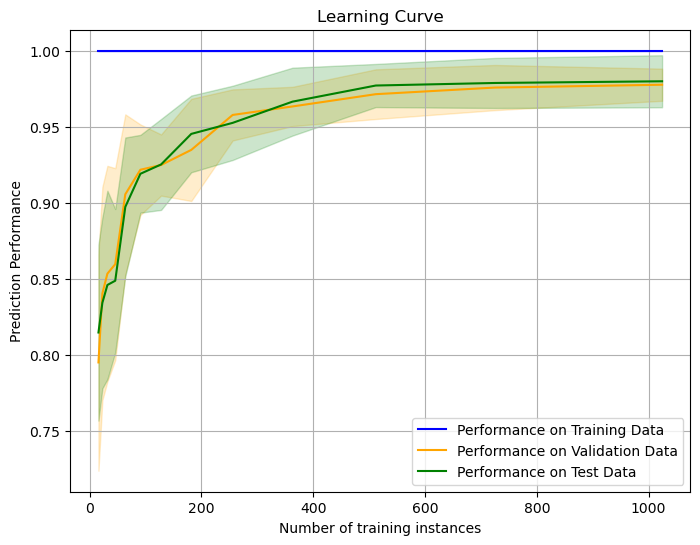

In [134]:
plot_learning_curve(anchor_sizes, scores_train, scores_valid, scores_test)

#### credit-g

In [150]:
df2 = pd.read_csv("credit-g-unprocessed.csv")
df2

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


In [151]:
y2 = df2['class'].map({'bad': 1, 'good': 0})
X2 = df2.drop(["class"], axis = 1)

In [152]:
anchor_sizes1, scores_train1, scores_valid1, scores_test1 =learning_curve(X2, y2, model_type= 'decision_tree' )
anchor_sizes2, scores_train2, scores_valid2, scores_test2 =learning_curve(X2, y2, model_type= 'random_forest' )

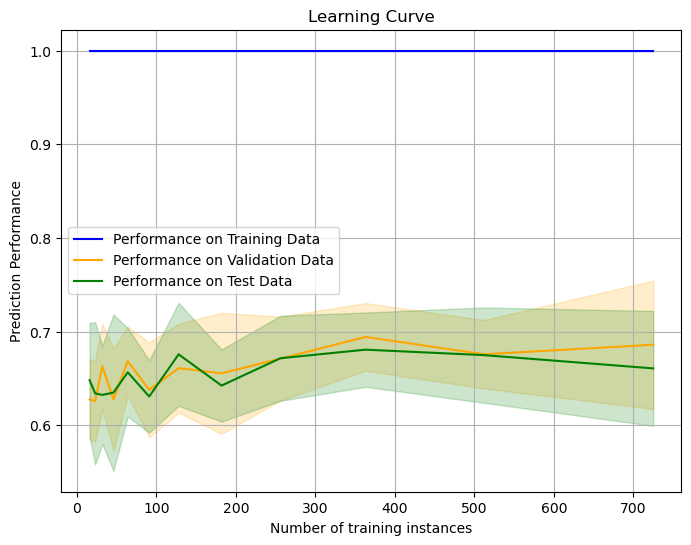

In [153]:
plot_learning_curve(anchor_sizes1, scores_train1, scores_valid1, scores_test1)

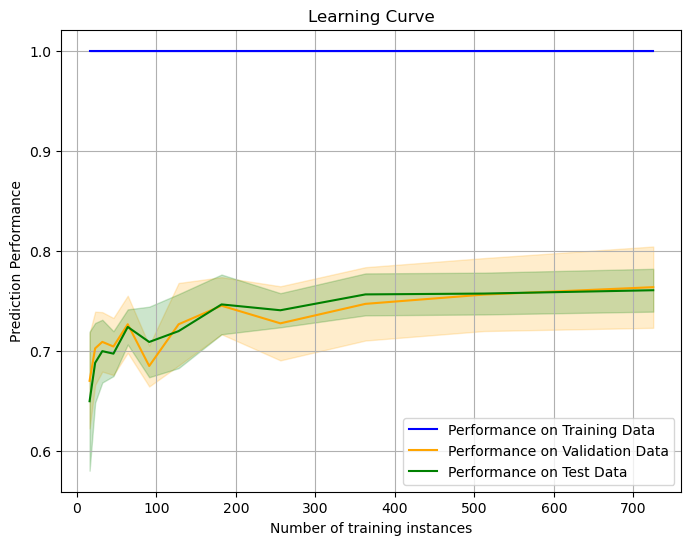

In [154]:
plot_learning_curve(anchor_sizes2, scores_train2, scores_valid2, scores_test2)